In [1]:
!curl http://d2l-data.s3-accelerate.amazonaws.com/pokemon.zip -o pokemon.zip #downloading zip file

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  114M  100  114M    0     0  55.8M      0  0:00:02  0:00:02 --:--:-- 55.8M


In [2]:
!unzip pokemon.zip -d /content/  # unzipping it


Streaming output truncated to the last 5000 lines.
 extracting: /content/pokemon/601/601-0.png  
 extracting: /content/pokemon/601/601-49.png  
 extracting: /content/pokemon/601/601-55.png  
 extracting: /content/pokemon/601/601-45.png  
 extracting: /content/pokemon/601/601-27.png  
 extracting: /content/pokemon/601/601-78.png  
 extracting: /content/pokemon/601/601-41.png  
 extracting: /content/pokemon/601/601-8.png  
 extracting: /content/pokemon/601/601-43.png  
 extracting: /content/pokemon/601/601-20.png  
 extracting: /content/pokemon/601/601-58.png  
 extracting: /content/pokemon/601/601-19.png  
 extracting: /content/pokemon/601/601-28.png  
 extracting: /content/pokemon/601/601-69.png  
 extracting: /content/pokemon/601/601-75.png  
 extracting: /content/pokemon/601/601-17.png  
 extracting: /content/pokemon/601/601-1.png  
 extracting: /content/pokemon/601/601-30.png  
 extracting: /content/pokemon/601/601-26.png  
 extracting: /content/pokemon/601/601-21.png  
 extracting:

In [3]:
# importing necessary libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
import torch.nn as nn

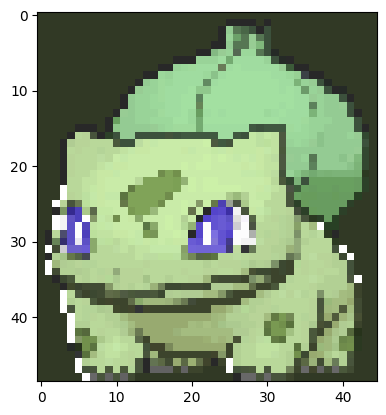

In [4]:
# checking how the images are
img= cv2.imread('/content/pokemon/1/1-0.png')
plt.imshow(img)
plt.show()

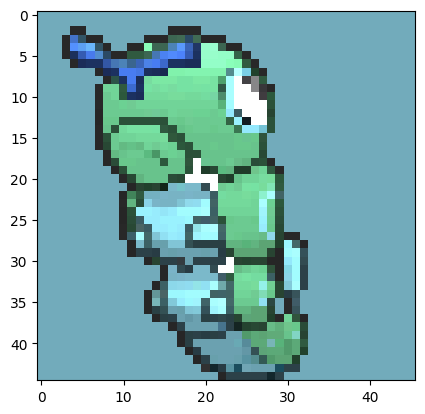

In [5]:
img= cv2.imread('/content/pokemon/10/10-0.png')
plt.imshow(img)
plt.show()

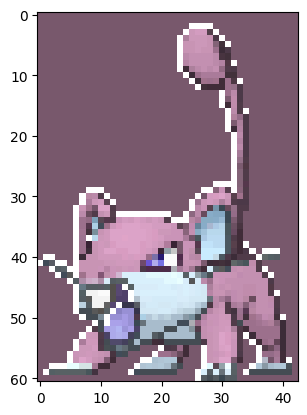

In [6]:
img= cv2.imread('/content/pokemon/19/19-0.png')
plt.imshow(img)
plt.show()

In [7]:
# some preprocessing
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),   # they did not have same shapes so making all of them of a same shape
    torchvision.transforms.ToTensor(),    # converting them to tensor
])
pokemons= torchvision.datasets.ImageFolder(root='/content/pokemon',transform=transformer)  # loades the image data by opening each image as a pil image from the directory with a structurehaving each class having their own directory

In [8]:
img.shape #image shape earlier

(61, 43, 3)

In [9]:
next(iter(pokemons))[0].shape  #image shape now


torch.Size([3, 64, 64])

In [10]:
pokemons  # can see the total number of images

Dataset ImageFolder
    Number of datapoints: 40597
    Root location: /content/pokemon
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [11]:
bs =40597//310  # setting my batch size

In [12]:
data = torch.utils.data.DataLoader(pokemons, batch_size=bs, shuffle=True)  # this shuffles the data and divide them into batches

In [13]:
next(iter(data))[1] # labels that we do not need

tensor([229, 253,  37,  35, 655, 299, 209, 213, 520, 701, 228, 499, 366, 210,
        210, 461, 289, 623, 280, 307, 303, 592, 563, 499, 328, 476,  14, 591,
        222, 321, 304, 302,  21, 482, 220, 353, 246, 210, 707, 461, 409, 310,
        554, 645, 498,  87, 211, 299, 385, 358, 416, 584, 442, 238, 603, 137,
        698, 465,  23, 215,  83,  21, 642, 608, 135, 566,  39, 495, 319, 517,
        319, 245, 275,  24, 590, 370, 197, 122, 692, 569, 265, 579, 488, 232,
        573, 317,  53, 495, 256, 419, 237, 329, 288, 360, 250, 401, 102, 234,
        390, 716, 354, 177, 176, 257, 308, 535,  83, 558, 594, 146,  37, 429,
        302, 297, 674, 230, 154, 693, 164, 561, 166, 397, 331, 677, 203, 297,
        695, 354, 272,  18])

In [14]:
next(iter(data))[0].shape     # shape of our batches

torch.Size([130, 3, 64, 64])

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
# making a function to generate random noise that will be our input
def generate_noise(batch_size=bs, dim=100):
    return torch.normal(mean=0, std=1, size=(batch_size, dim)).to(device)   # setting mean and std. deviation  = 0 and 1 respectively

In [57]:
# making generator class
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense= nn.Linear(100, 1024*4*4)     # dense layer so that it can be reshaped into 1024,4,4

        self.relu= nn.ReLU(inplace=True)

        # self.input_conv= nn.ConvTranspose2d(100,1024, kernel_size=2, stride=2)
        # self.norm= nn.BatchNorm2d(1024)

        self.conv1=nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)      #  115,8,8,512
        self.norm1= nn.BatchNorm2d(512)

        self.conv2=nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)       # 115,16,16,256
        self.norm2= nn.BatchNorm2d(256)


        self.conv3=nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)       # 115,32,32,128
        self.norm3= nn.BatchNorm2d(128)


        self.conv4=nn.ConvTranspose2d(128, 3, kernel_size=2, stride=2)         # 115,64,64,3
        self.tanh= nn.Tanh()

    def forward(self, x):
        x= self.dense(x)
        x= x.view(x.size(0), 1024, 4, 4)
        x= self.conv1(x)
        x= self.norm1(x)
        x= self.relu(x)
        x= self.conv2(x)
        x= self.norm2(x)
        x= self.relu(x)
        x= self.conv3(x)
        x= self.norm3(x)
        x= self.relu(x)
        x= self.conv4(x)
        x= self.tanh(x)
        return x


In [58]:
# just checking out the output shape for debugging
sample_noise= generate_noise()
generator= Generator().to(device)
fake_images= generator(sample_noise)
fake_images.shape

torch.Size([130, 3, 64, 64])

In [59]:
# making discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.machine=nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(1024, 1, kernel_size=4)
        )
    def forward(self,x):
        return self.machine(x)


In [60]:
q=next(iter(data))[0] .to(device)
discriminator= Discriminator().to(device)
discriminator(q).shape

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([130, 1, 1, 1])

In [61]:
def gan(gen,disc):
  for w in disc.parameters():
    w.requires_grad= False
  return nn.Sequential(gen,disc)

In [62]:
GAN = gan(generator,discriminator).to(device)

In [63]:
num_epochs =20

In [64]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [65]:
discriminator.apply(weights_init)
generator.apply(weights_init)
GAN.apply(weights_init)

Sequential(
  (0): Generator(
    (dense): Linear(in_features=100, out_features=16384, bias=True)
    (relu): ReLU(inplace=True)
    (conv1): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): ConvTranspose2d(128, 3, kernel_size=(2, 2), stride=(2, 2))
    (tanh): Tanh()
  )
  (1): Discriminator(
    (machine): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True

In [66]:
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_G = torch.optim.Adam(GAN.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [67]:
l = nn.BCEWithLogitsLoss(reduction='sum')

In [68]:

for i in range(num_epochs):
  total_batches = len(data)
  batch_size=130
  half_batch = int(batch_size / 2)

  for real_images,_ in data:
    real_images= (real_images)/127.5 - 1
    real_images= real_images.to(device)
    noise= generate_noise(batch_size=batch_size)
    fake_images= generator(noise)
    optimizer_D.zero_grad()
    real_pred= discriminator(real_images)
    loss_real= l(real_pred, torch.ones_like(real_pred))

    fake_pred= discriminator(fake_images)

    loss_fake= l(fake_pred, torch.zeros_like(fake_pred))
    loss_D= (loss_real + loss_fake) / 2
    loss_D.backward()
    optimizer_D.step()

    optimizer_G.zero_grad()
    fake_images= generator(noise)
    fake_pred= discriminator(fake_images)
    loss_G= l(fake_pred, torch.ones_like(fake_pred))
    loss_G.backward()
    optimizer_G.step()

  print('Epoch [{}/{}], Disc_LOSS: {:.8f},GEN_LOSS: {:.8f}'.format(i+1, num_epochs, loss_D.item(),loss_G.item()))
  with torch.no_grad():
      noise = generate_noise(batch_size=5)
      generated_imgs = generator(noise)
      generated_imgs = ((generated_imgs + 1) / 2)
      torchvision.utils.save_image(generated_imgs, 'generated_image_epoch_{}.png'.format(i+1))




Epoch [1/20], Disc_LOSS: 686.40014648,GEN_LOSS: 0.00718364
Epoch [2/20], Disc_LOSS: 754.45446777,GEN_LOSS: 0.00269326
Epoch [3/20], Disc_LOSS: 799.46453857,GEN_LOSS: 0.00128783
Epoch [4/20], Disc_LOSS: 832.94927979,GEN_LOSS: 0.00093708
Epoch [5/20], Disc_LOSS: 850.71746826,GEN_LOSS: 0.00062340
Epoch [6/20], Disc_LOSS: 878.19073486,GEN_LOSS: 0.00037561
Epoch [7/20], Disc_LOSS: 894.42712402,GEN_LOSS: 0.00030855
Epoch [8/20], Disc_LOSS: 903.41949463,GEN_LOSS: 0.00031934
Epoch [9/20], Disc_LOSS: 918.18048096,GEN_LOSS: 0.00020713
Epoch [10/20], Disc_LOSS: 932.24591064,GEN_LOSS: 0.00019121
Epoch [11/20], Disc_LOSS: 953.59942627,GEN_LOSS: 0.00013869
Epoch [12/20], Disc_LOSS: 970.98638916,GEN_LOSS: 0.00008488
Epoch [13/20], Disc_LOSS: 989.92388916,GEN_LOSS: 0.00008388
Epoch [14/20], Disc_LOSS: 990.87939453,GEN_LOSS: 0.00010454
Epoch [15/20], Disc_LOSS: 985.05700684,GEN_LOSS: 0.00007789
Epoch [16/20], Disc_LOSS: 1026.33166504,GEN_LOSS: 0.00005179
Epoch [17/20], Disc_LOSS: 1033.40417480,GEN_LOSS

In [69]:
pred= generator(generate_noise())

In [70]:
p=pred[0].view(3,64,64)

In [71]:
p=p.cpu().detach().numpy()
p=p.transpose(1,2,0)

In [72]:
p= p+1
p= p/2
p= p*255
p = p.astype(np.uint8)

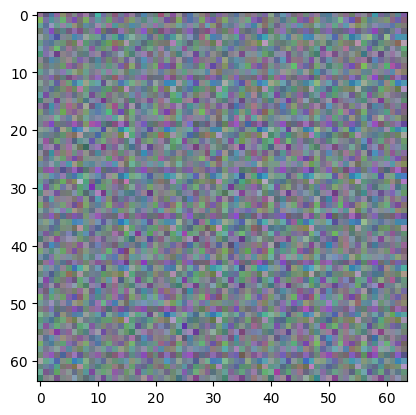

In [73]:
plt.imshow(p)